IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

LOADING DATA

In [2]:
# Loading the dataset
df = pd.read_excel('Telco_customer_churn.xlsx')

# Quick check to ensure we have both Churners (1) and Non-Churners (0)
print("Target Variable Distribution (0=Stay, 1=Churn):")
print(df['Churn Value'].value_counts())

Target Variable Distribution (0=Stay, 1=Churn):
Churn Value
0    5174
1    1869
Name: count, dtype: int64


DATA CLEANING

In [3]:
# Convert 'Total Charges' to numeric (force errors to NaN)
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Using assignment instead of inplace=True to silence the warnings
df['Total Charges'] = df['Total Charges'].fillna(0)

# Dropping columns that cause Data Leakage or are irrelevant
drop_cols = [
    'CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
    'Lat Long', 'Latitude', 'Longitude', 
    'Churn Label', 'Churn Score', 'Churn Reason'
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

PREPROCESSING (Feature Engineering)

In [4]:
# Defining X (Features) and y (Target)
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']

# Identify Numeric and Categorical columns automatically
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Create the transformer (Scaler for numbers, Encoder for text)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ])

# Splitting Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applying Transformations
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Getting feature names for the final chart
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)

print("Preprocessing Complete.")

Preprocessing Complete.


MODEL TRAINING

In [5]:
# Initializing Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Training the model
log_reg.fit(X_train_processed, y_train)

print("Model Trained Successfully.")

Model Trained Successfully.


EVALUATION


--- Model Performance ---
Accuracy: 0.7423704755145494
ROC-AUC Score: 0.8489963574362551

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



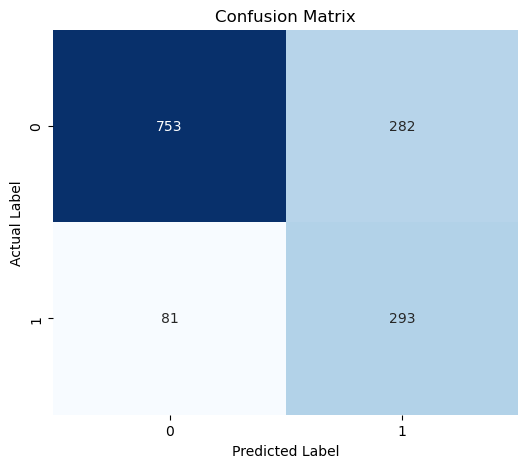

In [6]:
# Making predictions
y_pred = log_reg.predict(X_test_processed)
y_prob = log_reg.predict_proba(X_test_processed)[:, 1]

# Printing Metrics
print("\n--- Model Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plotting Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

BUSINESS INSIGHTS (Feature Importance)

C:\Users\zumha\AppData\Local\Temp\ipykernel_23992\2426280955.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coeffs, palette='viridis')


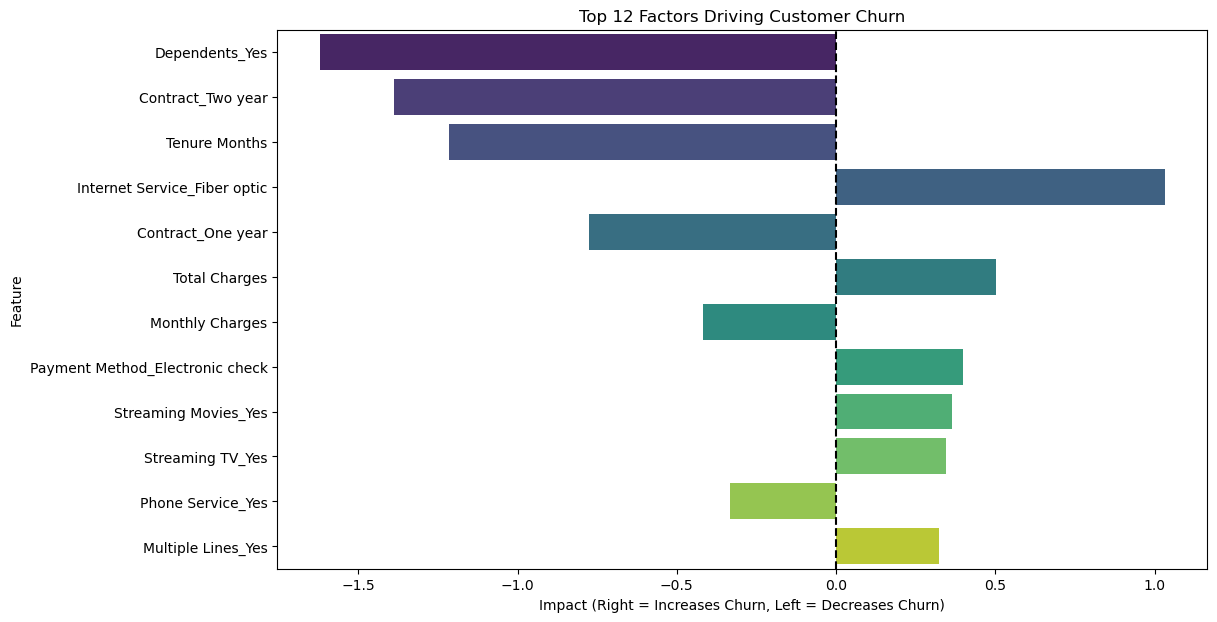

In [7]:
# Creating a dataframe of feature weights
coeffs = pd.DataFrame({
    'Feature': feature_names,
    'Weight': log_reg.coef_[0]
})

# Sort by absolute impact
coeffs['Abs_Weight'] = coeffs['Weight'].abs()
coeffs = coeffs.sort_values(by='Abs_Weight', ascending=False).head(12)

# Plotting the factors driving churn
plt.figure(figsize=(12, 7))
sns.barplot(x='Weight', y='Feature', data=coeffs, palette='viridis')
plt.title("Top 12 Factors Driving Customer Churn")
plt.xlabel("Impact (Right = Increases Churn, Left = Decreases Churn)")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()